In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
batch_size = 128
num_epochs = 200

z_dimension = 100

img_shape = (1, 32, 32)

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('/home/left5/datas/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(10 + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(z_dimension + 10, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [11]:
D = Discriminator().to(device)
G = Generator().to(device)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

adversarial_loss = nn.MSELoss()

D_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
G_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

In [12]:
condition = torch.from_numpy(np.arange(10)).cuda()

In [13]:
writer = SummaryWriter('./log/cgan')

In [14]:
img_path = "save_images/cgan"
if not os.path.exists(img_path): os.makedirs(img_path)

In [15]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (imgs, labels) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labels = labels.float().cuda()
        
        real = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()
        
        ########## G ##########
        z = torch.randn(imgs.size(0), z_dimension).cuda()
        fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        
        fake_imgs = G(z, fake_labels)
        fake_out = D(fake_imgs, fake_labels)
        g_loss = adversarial_loss(fake_out, real)
        
        G_optimezer.zero_grad()
        g_loss.backward()
        G_optimezer.step()
        #######################
        
        ########## D ##########
        real_out = D(real_imgs, labels)
        d_loss_real = adversarial_loss(real_out, real_labels)
        real_scores = real_out
        
        fake_out = D(fake_imgs.detach(), fake_labels)
        d_loss_fake = adversarial_loss(fake_out, fake)
        fake_scores = fake_out
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        D_optimezer.zero_grad()
        d_loss.backward()
        D_optimezer.step()
        #######################
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
        
    noise = torch.randn(10, z_dimension).cuda()
    condition_images = G(noise, condition)
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    writer.add_image('Condition Generator Image', make_grid(condition_images.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_images, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

Epoch [1/200], Step:  38400, d_loss: 5.032085, g_loss: 0.045761, real_scores: 4.352533, fake_scores: 0.959923
Finish Epoch [1/200], D Loss: 672.894625, G Loss: 56.092402
Epoch [2/200], Step:  38400, d_loss: 4.713851, g_loss: 0.082458, real_scores: 4.699137, fake_scores: 1.013919
Finish Epoch [2/200], D Loss: 340.268344, G Loss: 43.904060
Epoch [3/200], Step:  38400, d_loss: 6.079758, g_loss: 1.934808, real_scores: 2.974598, fake_scores: -0.343483
Finish Epoch [3/200], D Loss: 226.891616, G Loss: 34.252754
Epoch [4/200], Step:  38400, d_loss: 5.129977, g_loss: 0.422094, real_scores: 4.062723, fake_scores: 0.532064
Finish Epoch [4/200], D Loss: 166.580704, G Loss: 27.087468
Epoch [5/200], Step:  38400, d_loss: 5.382316, g_loss: 0.840755, real_scores: 3.673585, fake_scores: 0.118331
Finish Epoch [5/200], D Loss: 131.034551, G Loss: 20.906386
Epoch [6/200], Step:  38400, d_loss: 5.416888, g_loss: 0.486483, real_scores: 4.292892, fake_scores: 0.501630
Finish Epoch [6/200], D Loss: 109.60879

Finish Epoch [49/200], D Loss: 14.124173, G Loss: 2.462198
Epoch [50/200], Step:  38400, d_loss: 5.241833, g_loss: 1.304793, real_scores: 3.758764, fake_scores: 0.191509
Finish Epoch [50/200], D Loss: 13.934399, G Loss: 2.470427
Epoch [51/200], Step:  38400, d_loss: 5.497291, g_loss: 0.772377, real_scores: 4.241997, fake_scores: 1.040512
Finish Epoch [51/200], D Loss: 13.738873, G Loss: 2.419567
Epoch [52/200], Step:  38400, d_loss: 5.698829, g_loss: 0.928124, real_scores: 4.110771, fake_scores: 0.632853
Finish Epoch [52/200], D Loss: 13.356619, G Loss: 2.315060
Epoch [53/200], Step:  38400, d_loss: 5.724307, g_loss: 1.205686, real_scores: 3.541277, fake_scores: 0.172730
Finish Epoch [53/200], D Loss: 13.152846, G Loss: 2.296179
Epoch [54/200], Step:  38400, d_loss: 5.463612, g_loss: 0.719357, real_scores: 4.555578, fake_scores: 1.279172
Finish Epoch [54/200], D Loss: 12.915851, G Loss: 2.339034
Epoch [55/200], Step:  38400, d_loss: 5.101917, g_loss: 1.246964, real_scores: 3.343451, fa

Epoch [98/200], Step:  38400, d_loss: 4.888964, g_loss: 0.791891, real_scores: 4.074574, fake_scores: 0.371766
Finish Epoch [98/200], D Loss: 6.897167, G Loss: 1.318188
Epoch [99/200], Step:  38400, d_loss: 4.892773, g_loss: 0.774994, real_scores: 4.453850, fake_scores: 0.621761
Finish Epoch [99/200], D Loss: 6.851233, G Loss: 1.262522
Epoch [100/200], Step:  38400, d_loss: 5.089312, g_loss: 0.967450, real_scores: 3.655733, fake_scores: 0.187647
Finish Epoch [100/200], D Loss: 6.759334, G Loss: 1.264559
Epoch [101/200], Step:  38400, d_loss: 5.227621, g_loss: 0.984046, real_scores: 3.557869, fake_scores: 0.166415
Finish Epoch [101/200], D Loss: 6.677160, G Loss: 1.282206
Epoch [102/200], Step:  38400, d_loss: 5.186668, g_loss: 0.993106, real_scores: 4.090302, fake_scores: 0.159618
Finish Epoch [102/200], D Loss: 6.589483, G Loss: 1.261393
Epoch [103/200], Step:  38400, d_loss: 5.650578, g_loss: 0.971261, real_scores: 3.918968, fake_scores: 0.405782
Finish Epoch [103/200], D Loss: 6.596

Epoch [146/200], Step:  38400, d_loss: 4.856156, g_loss: 1.031819, real_scores: 4.296118, fake_scores: 0.305619
Finish Epoch [146/200], D Loss: 4.519822, G Loss: 0.895125
Epoch [147/200], Step:  38400, d_loss: 5.576004, g_loss: 1.011977, real_scores: 3.803638, fake_scores: 0.245002
Finish Epoch [147/200], D Loss: 4.464695, G Loss: 0.891399
Epoch [148/200], Step:  38400, d_loss: 5.544638, g_loss: 0.670462, real_scores: 4.500177, fake_scores: 0.881588
Finish Epoch [148/200], D Loss: 4.464261, G Loss: 0.878158
Epoch [149/200], Step:  38400, d_loss: 5.285899, g_loss: 0.830132, real_scores: 4.488027, fake_scores: 0.990971
Finish Epoch [149/200], D Loss: 4.437479, G Loss: 0.890804
Epoch [150/200], Step:  38400, d_loss: 5.199495, g_loss: 0.800617, real_scores: 4.039030, fake_scores: 0.421404
Finish Epoch [150/200], D Loss: 4.415590, G Loss: 0.870540
Epoch [151/200], Step:  38400, d_loss: 5.292921, g_loss: 0.995666, real_scores: 4.064771, fake_scores: 0.321110
Finish Epoch [151/200], D Loss: 4

Epoch [194/200], Step:  38400, d_loss: 5.661208, g_loss: 1.817704, real_scores: 3.397838, fake_scores: -0.132717
Finish Epoch [194/200], D Loss: 3.350308, G Loss: 0.692577
Epoch [195/200], Step:  38400, d_loss: 5.861861, g_loss: 1.701306, real_scores: 3.103317, fake_scores: -0.035656
Finish Epoch [195/200], D Loss: 3.323675, G Loss: 0.687028
Epoch [196/200], Step:  38400, d_loss: 4.945563, g_loss: 0.640148, real_scores: 4.041309, fake_scores: 0.527263
Finish Epoch [196/200], D Loss: 3.317534, G Loss: 0.689602
Epoch [197/200], Step:  38400, d_loss: 4.913246, g_loss: 1.070968, real_scores: 4.033340, fake_scores: 0.254002
Finish Epoch [197/200], D Loss: 3.307643, G Loss: 0.684433
Epoch [198/200], Step:  38400, d_loss: 4.906668, g_loss: 0.852445, real_scores: 3.923775, fake_scores: 0.291345
Finish Epoch [198/200], D Loss: 3.302930, G Loss: 0.677669
Epoch [199/200], Step:  38400, d_loss: 5.324225, g_loss: 1.028347, real_scores: 3.767110, fake_scores: 0.228408
Finish Epoch [199/200], D Loss:

In [16]:
writer.close()

In [17]:
torch.save(D.state_dict(), './ser/cgan_discriminator.pkl')
torch.save(G.state_dict(), './ser/cgan_generator.pkl')

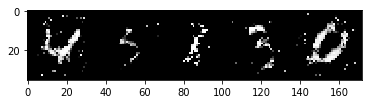

In [37]:
l = torch.from_numpy(np.array([4,5,1,3,0])).cuda()
z = torch.randn(5, z_dimension).to(device)
images = G(z, l)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()